In [1]:
# Goal : To classify the type of ovarian cancer from microscopy scans of biopsy samples.

# Search SoTA model on Kaggle Approach, Papers with code - Medical Data, Graph Transformer, GNN, Global and Local Analysis

# You should manage, including differences in image dimensions, quality, slide staining techniques, and more

# There are 2 types of images - TMA and WSI (25 images are TMA and 513(rest) are WSI)


In [2]:
import sys
sys.prefix

'/projectnb/cs640grp/students/avarshn/.conda/envs/ocean'

# Check if GPU is available

In [3]:
import torch

In [4]:
torch.cuda.is_available()

True

In [5]:
!nvidia smi


/bin/bash: nvidia: command not found


In [6]:
!lspci | grep -i nvidia

02:00.0 3D controller: NVIDIA Corporation GP100GL [Tesla P100 PCIe 12GB] (rev a1)
82:00.0 3D controller: NVIDIA Corporation GP100GL [Tesla P100 PCIe 12GB] (rev a1)


# Import Libraries

In [7]:
import os
from time import time
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from PIL import Image
import cv2

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from torchsummary import summary

import torchvision
from torchvision import transforms, utils

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import resnet18, ResNet18_Weights

# Configurations

In [10]:
CONFIG = {
    "model_name" : "efficientnet_b3"
}

In [88]:
if CONFIG["model_name"] == "efficientnet_b3":

    CONFIG.update({
            "seed": 42,
            "num_classes": 5,
            "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
            
            # "valid_batch_size": 32,
            "embedding_save_folder" : "./models/efficientnet_b3/embeddings/",
            "feature_input_size" : 1536,
            "model_save_folder" : "./models/efficientnet_b3/model_checkpoints/",
        
            "batch_size" : 8,
            "train_batch_size" : 8,
            "epochs" : 10,
            "learning_rate" : 1e-5,
            "weight_decay" : 1e-3
    })

In [20]:
if CONFIG["model_name"] == "efficientnet_b0":

    CONFIG.update({
            "seed": 42,
            "num_classes": 5,
            "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
            
            # "valid_batch_size": 32,
            "embedding_save_folder" : "./models/efficientnet_b0/embeddings/",
            "feature_input_size" : 1280,
            "model_save_folder" : "./models/efficientnet_b0/model_checkpoints/",
        
            "batch_size" : 8,
            "epochs" : 40,
            "learning_rate" : 1e-5,
            "weight_decay" : 1e-2
    })

In [21]:
if CONFIG["model_name"] == "resnet18":

    CONFIG.update({
            "seed": 42,
            "num_classes": 5,
            "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
            
            # "valid_batch_size": 32,
            "embedding_save_folder" : "./models/resnet18/embeddings/",
            "feature_input_size" : 512,
            "model_save_folder" : "./models/resnet18/model_checkpoints/",
        
            "batch_size" : 32,
            "epochs" : 50,
            "learning_rate" : 1e-4,
            "weight_decay" : 1e-3
    })

In [22]:
CONFIG

{'model_name': 'efficientnet_b3',
 'seed': 42,
 'num_classes': 5,
 'device': device(type='cuda', index=0),
 'embedding_save_folder': './models/efficientnet_b3/embeddings/',
 'feature_input_size': 1536,
 'model_save_folder': './models/efficientnet_b3/model_checkpoints/',
 'batch_size': 8,
 'epochs': 10,
 'learning_rate': 1e-05,
 'weight_decay': 0.001}

In [23]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

# Merge Numpy arrays

In [24]:
embeddings_arr_list = []
labels_arr_list = []

for file in os.listdir(CONFIG["embedding_save_folder"]):
    if file.endswith(".npz"):
        if "train_embeddings_and_labels_" in file:
            np_arr = np.load(CONFIG["embedding_save_folder"] + file)
            embeddings_arr_list.append(np_arr["embeddings"])
            labels_arr_list.append(np_arr["labels"])
            # labels_arr = np.concatenate((labels_arr, np_arr["labels"]), axis = 0)

In [25]:
all_embeddings = np.concatenate(embeddings_arr_list)
all_embeddings.shape

(1505, 1536)

In [26]:
all_labels = np.concatenate(labels_arr_list)
all_labels.shape

(1505,)

In [27]:
# Balanced Dataset with Augmentation
np.unique(all_labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([329, 300, 285, 294, 297]))

In [28]:
save_location = f'{CONFIG["embedding_save_folder"]}{CONFIG["model_name"]}_train_embeddings_and_labels.npz'
print(save_location)

np.savez(save_location, embeddings = all_embeddings, labels = all_labels)

./models/efficientnet_b3/embeddings/efficientnet_b3_train_embeddings_and_labels.npz


# Custom Dataset

In [29]:
Image.MAX_IMAGE_PIXELS = None

In [30]:
class ocean_embedding_dataset(Dataset):
    
    def __init__(self, numpy_file_name):
        
        self.ocean_np_arr = np.load(numpy_file_name)

    def __len__(self):
        return self.ocean_np_arr["labels"].shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.ocean_np_arr["embeddings"][idx]
        image = torch.tensor(image)
        
        label = self.ocean_np_arr["labels"][idx]

        return image, label
        

In [31]:
train_np_arr_path = f'{CONFIG["embedding_save_folder"]}{CONFIG["model_name"]}_train_embeddings_and_labels.npz'
test_np_arr_path = f'{CONFIG["embedding_save_folder"]}{CONFIG["model_name"]}_test_embeddings_and_labels.npz'


In [32]:
train_dataset = ocean_embedding_dataset(train_np_arr_path)

test_dataset = ocean_embedding_dataset(test_np_arr_path)

## Testing

In [33]:
train_dataset.__len__()

1505

In [34]:
a,b = train_dataset.__getitem__(torch.tensor(10))

In [35]:
a

tensor([-0.1408, -0.2029, -0.1339,  ..., -0.0392, -0.1847,  0.1026])

In [36]:
b

3

In [37]:
train_dataset.ocean_np_arr["labels"]

array([2, 4, 4, ..., 2, 0, 3])

# Class Weights - From Training Data since the dataset is imbalanced

## Not using Class Weights in nn.CrossEntropyLoss() since we have balanced data while Augmentation itself

In [38]:
train_dataset.ocean_np_arr["labels"]

array([2, 4, 4, ..., 2, 0, 3])

* Class weight Formula -
  
class_weight_of_that_class = $\frac{\text{Total samples}}{\text{Total classes * samples of that class}}$

In [39]:
# NumPy array of class labels - labels_arr

labels_arr = train_dataset.ocean_np_arr["labels"].copy()

class_weights = compute_class_weight('balanced',classes = np.unique(labels_arr), y = labels_arr)

In [40]:
class_weights

array([0.91489362, 1.00333333, 1.05614035, 1.02380952, 1.01346801])

In [41]:
# label_mapper = {'HGSC' : 0, 'EC' : 1, 'MC' : 2, 'CC' : 3, 'LGSC' : 4}
# Train Label Distribution
np.unique(labels_arr, return_counts = True)

(array([0, 1, 2, 3, 4]), array([329, 300, 285, 294, 297]))

In [42]:
class_weights_tensor = torch.tensor(class_weights)
class_weights_tensor

tensor([0.9149, 1.0033, 1.0561, 1.0238, 1.0135], dtype=torch.float64)

# Train - Evaluation, Training, Architecture

In [44]:
# Use `torch.no_grad()` here to disable gradient calculation. 
# It will reduce memory consumption as we don't need to compute gradients in inference.

@torch.no_grad()
def evaluate(model, testloader, criterion, device):
    
    model.eval()
    
    # Keep track of loss and other evaluation metrics
    test_loss = 0.0

    YPredict = []
    YTrue = []
    
    # Loop through each batch on test set
    for i, (images, labels) in enumerate(testloader, 1):
        
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)

        loss = criterion(logits, labels)
        
        test_loss += loss.detach().item()

        predictions = torch.argmax(logits, dim = 1)
        predictions = predictions.view(-1)
        YTrue.extend(labels.tolist())
        YPredict.extend(predictions.tolist())

    # Compute Scores
    accuracy = accuracy_score(YTrue, YPredict)
    f1 = f1_score(YTrue, YPredict, average = "macro")
    print("Classification report :")
    print(classification_report(YTrue, YPredict))

    return (test_loss/i, accuracy, f1) ## avg loss and acc over all batches


In [45]:
def train_model(model, trainloader, testloader, CONFIG):
    
    optimizer = AdamW(model.parameters(), lr = CONFIG["learning_rate"], weight_decay = CONFIG["weight_decay"])

    # criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)

    criterion = nn.CrossEntropyLoss()


    ## Measure runtime
    t_start = time()
    
    ## Store training log
    history = defaultdict(list)
    
    # We will train the model `num_epochs` times
    for i in range(1, CONFIG["epochs"]+1):

        # Training
        train_loss, train_acc, train_f1 = train_one_epoch(model = model, trainloader = trainloader, optimizer = optimizer, criterion = criterion, device = CONFIG["device"])

        # Model Checkpointing
        if i%10==0:
            torch.save(model.state_dict(), f'{CONFIG["model_save_folder"]}epoch{i}_batch_size{CONFIG["batch_size"]}.pth')

        # Evaluate on test set
        test_loss, test_acc, test_f1 = evaluate(model = model, testloader = testloader, criterion = criterion, device = CONFIG["device"])

        ## Store train/test loss, accuracy, f1 scores
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        history["test_f1"].append(test_f1)

        
        
        ## print out train/test loss, accuracy
        print(f'Epoch: {i} | Runtime: {((time()-t_start)/60):.2f}[m] | train_loss: {train_loss:.3f} | test_loss: {test_loss:.3f} | train_acc: {train_acc:.3f} |  test_acc: {test_acc:.3f} | train_f1: {train_f1:.3f} | test_f1: {test_f1:.3f}')    
    return history

In [52]:
def train_one_epoch(model, trainloader, device, optimizer, criterion):
    """
      Train 1 epoch on trainloader."
    """

    model = model.train()
    
    # Keep track of loss and other evaluation metrics
    train_loss = 0.0

    YPredict = []
    YTrue = []

    ## Loop over all the batches
    for i, (images, labels) in tqdm(enumerate(trainloader, 1), total=len(trainloader), desc=f"Training on whole batch..."):
            
        # Move images and labels to `device` (CPU or GPU)
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)

        # print(logits)
        # print(labels)
        # print(logits.dtype, labels.dtype)
        # print(type(labels[0]))
        # print(type(labels))
        loss = criterion(logits, labels)
        # loss = criterion(logits, labels.to(torch.long))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute loss and accuracy for this batch
        train_loss += loss.detach().item()

        predictions = torch.argmax(logits, dim = 1)
        predictions = predictions.view(-1)
        YTrue.extend(labels.tolist())
        YPredict.extend(predictions.tolist())


    # Compute Scores
    accuracy = accuracy_score(YTrue, YPredict)
    f1 = f1_score(YTrue, YPredict, average = "macro")

    return (train_loss/i, accuracy, f1) ## avg loss and acc over all batches


In [53]:
class Baseline_Model(nn.Module):

    def __init__(self):
        super().__init__()
        
        # self.base_model_headless = base_layers
        # self.base_model_headless.requires_grad = False
        
        self.fc1 = nn.Linear(CONFIG["feature_input_size"], 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 5)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.1)


    def forward(self, x):
        # x = self.base_model_headless(x)
        # # print("Output shape after Passing through Pretrained Model")
        # # print(x.shape)

        # # Flatten
        # x = x.view((x.shape[0], -1))

        # FCNN
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        # print(x.shape)

        return x      

# Train the Model

## DataLoader

* The EOFError you encountered in your DataLoader worker process could be related to using multiple workers (num_workers = 2)


1) Concurrency Issues:

    * When using multiple worker processes (num_workers > 0), there is potential for concurrency issues, especially when reading data from a file or other data sources. If your dataset is not designed to handle concurrent access properly, it can result in unexpected errors like EOFError.
  
2) Use torch.utils.data.SequentialSampler:
    * Instead of relying on the default random sampler, you can use SequentialSampler to ensure that the data is loaded in a sequential order, which might help in scenarios where the order of loading matters.



In [89]:
trainloader = DataLoader(train_dataset, batch_size = CONFIG['train_batch_size'], shuffle = True, drop_last = True)

testloader = DataLoader(test_dataset, batch_size = CONFIG['batch_size'], shuffle = False, drop_last = True)

In [90]:
# Initialize Model
model = Baseline_Model().to(CONFIG["device"])

In [91]:
summary(model, input_size = (CONFIG["feature_input_size"],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         393,472
              ReLU-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                   [-1, 32]           8,224
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 5]             165
Total params: 401,861
Trainable params: 401,861
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 1.53
Estimated Total Size (MB): 1.55
----------------------------------------------------------------


In [92]:
# ## compute accuracy score in a batch
# def compute_accuracy(logits, labels, batch_size):
#     ''' 
#       Obtain accuracy for a training batch 
#       logits: float Tensor, shape (batch_size, num_classes),  output from the model
#       labels: Long Tensor, shape (batch_size, ), contains labels for the predictions
#       batch_size: int, batch size

#       Return accuracy for this batch, which should be a float number
#     '''
    
#     # Write your code in this block ----------------
    
#     predictions = torch.argmax(logits, dim = 1)
#     predictions = predictions.view(-1)
    
#     total_correct = (labels == predictions).sum().item()
#     accuracy = total_correct/batch_size
    
#     return accuracy

In [96]:
# Train Model

history_model = train_model(model, trainloader, testloader, CONFIG)

Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 132.39it/s]
/projectnb/cs640grp/students/avarshn/.conda/envs/ocean/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projectnb/cs640grp/students/avarshn/.conda/envs/ocean/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projectnb/cs640grp/students/avarshn/.conda/envs/ocean/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in

Classification report :
              precision    recall  f1-score   support

           0       0.41      1.00      0.59        53
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        10

    accuracy                           0.41       128
   macro avg       0.08      0.20      0.12       128
weighted avg       0.17      0.41      0.24       128

Epoch: 1 | Runtime: 0.19[m] | train_loss: 1.601 | test_loss: 1.557 | train_acc: 0.226 |  test_acc: 0.414 | train_f1: 0.099 | test_f1: 0.117


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.56it/s]
/projectnb/cs640grp/students/avarshn/.conda/envs/ocean/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projectnb/cs640grp/students/avarshn/.conda/envs/ocean/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projectnb/cs640grp/students/avarshn/.conda/envs/ocean/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in

Classification report :
              precision    recall  f1-score   support

           0       0.41      1.00      0.59        53
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        10

    accuracy                           0.41       128
   macro avg       0.08      0.20      0.12       128
weighted avg       0.17      0.41      0.24       128

Epoch: 2 | Runtime: 0.38[m] | train_loss: 1.574 | test_loss: 1.541 | train_acc: 0.246 |  test_acc: 0.414 | train_f1: 0.126 | test_f1: 0.117


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.64it/s]
/projectnb/cs640grp/students/avarshn/.conda/envs/ocean/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projectnb/cs640grp/students/avarshn/.conda/envs/ocean/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projectnb/cs640grp/students/avarshn/.conda/envs/ocean/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in

Classification report :
              precision    recall  f1-score   support

           0       0.42      0.83      0.56        53
           1       0.30      0.10      0.15        30
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        24
           4       0.08      0.10      0.09        10

    accuracy                           0.38       128
   macro avg       0.16      0.21      0.16       128
weighted avg       0.25      0.38      0.27       128

Epoch: 3 | Runtime: 0.57[m] | train_loss: 1.536 | test_loss: 1.523 | train_acc: 0.310 |  test_acc: 0.375 | train_f1: 0.226 | test_f1: 0.159


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.85it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.43      0.75      0.55        53
           1       0.33      0.17      0.22        30
           2       0.33      0.18      0.24        11
           3       0.00      0.00      0.00        24
           4       0.08      0.10      0.09        10

    accuracy                           0.38       128
   macro avg       0.24      0.24      0.22       128
weighted avg       0.29      0.38      0.31       128

Epoch: 4 | Runtime: 0.76[m] | train_loss: 1.495 | test_loss: 1.511 | train_acc: 0.380 |  test_acc: 0.375 | train_f1: 0.330 | test_f1: 0.219


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.73it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.43      0.74      0.55        53
           1       0.40      0.13      0.20        30
           2       0.44      0.36      0.40        11
           3       0.00      0.00      0.00        24
           4       0.06      0.10      0.08        10

    accuracy                           0.38       128
   macro avg       0.27      0.27      0.24       128
weighted avg       0.32      0.38      0.31       128

Epoch: 5 | Runtime: 0.94[m] | train_loss: 1.452 | test_loss: 1.488 | train_acc: 0.465 |  test_acc: 0.375 | train_f1: 0.443 | test_f1: 0.244


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.72it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.45      0.66      0.53        53
           1       0.29      0.17      0.21        30
           2       0.42      0.45      0.43        11
           3       0.29      0.08      0.13        24
           4       0.07      0.10      0.08        10

    accuracy                           0.38       128
   macro avg       0.30      0.29      0.28       128
weighted avg       0.35      0.38      0.34       128

Epoch: 6 | Runtime: 1.13[m] | train_loss: 1.403 | test_loss: 1.463 | train_acc: 0.511 |  test_acc: 0.375 | train_f1: 0.498 | test_f1: 0.279


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.74it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        53
           1       0.30      0.23      0.26        30
           2       0.35      0.64      0.45        11
           3       0.25      0.12      0.17        24
           4       0.06      0.10      0.08        10

    accuracy                           0.38       128
   macro avg       0.30      0.33      0.30       128
weighted avg       0.37      0.38      0.36       128

Epoch: 7 | Runtime: 1.32[m] | train_loss: 1.356 | test_loss: 1.466 | train_acc: 0.530 |  test_acc: 0.375 | train_f1: 0.520 | test_f1: 0.301


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.77it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.58      0.57      0.57        53
           1       0.34      0.33      0.34        30
           2       0.39      0.82      0.53        11
           3       0.25      0.08      0.12        24
           4       0.06      0.10      0.08        10

    accuracy                           0.41       128
   macro avg       0.33      0.38      0.33       128
weighted avg       0.41      0.41      0.39       128

Epoch: 8 | Runtime: 1.51[m] | train_loss: 1.313 | test_loss: 1.461 | train_acc: 0.551 |  test_acc: 0.406 | train_f1: 0.542 | test_f1: 0.328


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.81it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.49      0.58      0.53        53
           1       0.25      0.17      0.20        30
           2       0.39      0.82      0.53        11
           3       0.17      0.04      0.07        24
           4       0.06      0.10      0.08        10

    accuracy                           0.37       128
   macro avg       0.27      0.34      0.28       128
weighted avg       0.33      0.37      0.33       128

Epoch: 9 | Runtime: 1.70[m] | train_loss: 1.264 | test_loss: 1.438 | train_acc: 0.577 |  test_acc: 0.367 | train_f1: 0.568 | test_f1: 0.281


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 132.60it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.56      0.55      0.55        53
           1       0.27      0.20      0.23        30
           2       0.38      0.91      0.54        11
           3       0.20      0.08      0.12        24
           4       0.06      0.10      0.07        10

    accuracy                           0.38       128
   macro avg       0.29      0.37      0.30       128
weighted avg       0.37      0.38      0.36       128

Epoch: 10 | Runtime: 1.89[m] | train_loss: 1.224 | test_loss: 1.444 | train_acc: 0.576 |  test_acc: 0.375 | train_f1: 0.566 | test_f1: 0.303


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.65it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.53      0.58      0.56        53
           1       0.32      0.20      0.24        30
           2       0.36      0.91      0.51        11
           3       0.17      0.04      0.07        24
           4       0.06      0.10      0.07        10

    accuracy                           0.38       128
   macro avg       0.29      0.37      0.29       128
weighted avg       0.36      0.38      0.35       128

Epoch: 11 | Runtime: 2.08[m] | train_loss: 1.179 | test_loss: 1.438 | train_acc: 0.594 |  test_acc: 0.383 | train_f1: 0.584 | test_f1: 0.291


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.82it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.54      0.49      0.51        53
           1       0.28      0.23      0.25        30
           2       0.31      0.91      0.47        11
           3       0.17      0.04      0.07        24
           4       0.06      0.10      0.07        10

    accuracy                           0.35       128
   macro avg       0.27      0.35      0.28       128
weighted avg       0.35      0.35      0.33       128

Epoch: 12 | Runtime: 2.26[m] | train_loss: 1.136 | test_loss: 1.445 | train_acc: 0.614 |  test_acc: 0.352 | train_f1: 0.607 | test_f1: 0.275


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.86it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.56      0.47      0.51        53
           1       0.26      0.20      0.23        30
           2       0.34      0.91      0.50        11
           3       0.00      0.00      0.00        24
           4       0.16      0.40      0.23        10

    accuracy                           0.35       128
   macro avg       0.26      0.40      0.29       128
weighted avg       0.33      0.35      0.33       128

Epoch: 13 | Runtime: 2.45[m] | train_loss: 1.109 | test_loss: 1.441 | train_acc: 0.619 |  test_acc: 0.352 | train_f1: 0.612 | test_f1: 0.293


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.67it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.54      0.47      0.51        53
           1       0.25      0.23      0.24        30
           2       0.38      0.82      0.51        11
           3       0.11      0.04      0.06        24
           4       0.14      0.30      0.19        10

    accuracy                           0.35       128
   macro avg       0.28      0.37      0.30       128
weighted avg       0.35      0.35      0.34       128

Epoch: 14 | Runtime: 2.64[m] | train_loss: 1.071 | test_loss: 1.423 | train_acc: 0.636 |  test_acc: 0.352 | train_f1: 0.630 | test_f1: 0.303


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.92it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.56      0.42      0.48        53
           1       0.30      0.30      0.30        30
           2       0.34      0.91      0.50        11
           3       0.00      0.00      0.00        24
           4       0.15      0.40      0.22        10

    accuracy                           0.35       128
   macro avg       0.27      0.40      0.30       128
weighted avg       0.35      0.35      0.33       128

Epoch: 15 | Runtime: 2.83[m] | train_loss: 1.030 | test_loss: 1.454 | train_acc: 0.653 |  test_acc: 0.352 | train_f1: 0.646 | test_f1: 0.300


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.64it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.54      0.51      0.52        53
           1       0.22      0.20      0.21        30
           2       0.35      0.64      0.45        11
           3       0.10      0.04      0.06        24
           4       0.14      0.30      0.19        10

    accuracy                           0.34       128
   macro avg       0.27      0.34      0.29       128
weighted avg       0.34      0.34      0.33       128

Epoch: 16 | Runtime: 3.02[m] | train_loss: 1.010 | test_loss: 1.405 | train_acc: 0.627 |  test_acc: 0.344 | train_f1: 0.619 | test_f1: 0.288


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.87it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        53
           1       0.26      0.27      0.26        30
           2       0.35      0.82      0.49        11
           3       0.18      0.08      0.11        24
           4       0.17      0.40      0.24        10

    accuracy                           0.34       128
   macro avg       0.30      0.39      0.31       128
weighted avg       0.37      0.34      0.33       128

Epoch: 17 | Runtime: 3.20[m] | train_loss: 0.980 | test_loss: 1.431 | train_acc: 0.671 |  test_acc: 0.336 | train_f1: 0.667 | test_f1: 0.310


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.90it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.53      0.40      0.45        53
           1       0.28      0.30      0.29        30
           2       0.35      0.82      0.49        11
           3       0.12      0.04      0.06        24
           4       0.18      0.40      0.25        10

    accuracy                           0.34       128
   macro avg       0.29      0.39      0.31       128
weighted avg       0.35      0.34      0.33       128

Epoch: 18 | Runtime: 3.39[m] | train_loss: 0.943 | test_loss: 1.439 | train_acc: 0.680 |  test_acc: 0.344 | train_f1: 0.673 | test_f1: 0.308


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 135.00it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.55      0.40      0.46        53
           1       0.25      0.27      0.26        30
           2       0.35      0.82      0.49        11
           3       0.11      0.04      0.06        24
           4       0.17      0.40      0.24        10

    accuracy                           0.34       128
   macro avg       0.29      0.38      0.30       128
weighted avg       0.35      0.34      0.32       128

Epoch: 19 | Runtime: 3.58[m] | train_loss: 0.916 | test_loss: 1.443 | train_acc: 0.693 |  test_acc: 0.336 | train_f1: 0.689 | test_f1: 0.302


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.73it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.52      0.42      0.46        53
           1       0.23      0.23      0.23        30
           2       0.35      0.82      0.49        11
           3       0.14      0.04      0.06        24
           4       0.17      0.40      0.24        10

    accuracy                           0.34       128
   macro avg       0.28      0.38      0.30       128
weighted avg       0.34      0.34      0.32       128

Epoch: 20 | Runtime: 3.77[m] | train_loss: 0.896 | test_loss: 1.440 | train_acc: 0.684 |  test_acc: 0.336 | train_f1: 0.681 | test_f1: 0.298


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 135.06it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.54      0.38      0.44        53
           1       0.25      0.33      0.29        30
           2       0.33      0.64      0.44        11
           3       0.12      0.04      0.06        24
           4       0.18      0.40      0.25        10

    accuracy                           0.33       128
   macro avg       0.29      0.36      0.30       128
weighted avg       0.35      0.33      0.32       128

Epoch: 21 | Runtime: 3.96[m] | train_loss: 0.871 | test_loss: 1.438 | train_acc: 0.704 |  test_acc: 0.328 | train_f1: 0.699 | test_f1: 0.296


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.88it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.52      0.42      0.46        53
           1       0.27      0.33      0.30        30
           2       0.33      0.64      0.44        11
           3       0.12      0.04      0.06        24
           4       0.20      0.40      0.27        10

    accuracy                           0.34       128
   macro avg       0.29      0.37      0.31       128
weighted avg       0.35      0.34      0.33       128

Epoch: 22 | Runtime: 4.14[m] | train_loss: 0.845 | test_loss: 1.442 | train_acc: 0.714 |  test_acc: 0.344 | train_f1: 0.711 | test_f1: 0.306


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.89it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.56      0.36      0.44        53
           1       0.23      0.30      0.26        30
           2       0.30      0.55      0.39        11
           3       0.17      0.08      0.11        24
           4       0.17      0.40      0.24        10

    accuracy                           0.31       128
   macro avg       0.29      0.34      0.29       128
weighted avg       0.36      0.31      0.32       128

Epoch: 23 | Runtime: 4.33[m] | train_loss: 0.813 | test_loss: 1.446 | train_acc: 0.718 |  test_acc: 0.312 | train_f1: 0.715 | test_f1: 0.288


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.78it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.53      0.40      0.45        53
           1       0.23      0.27      0.25        30
           2       0.30      0.55      0.39        11
           3       0.11      0.04      0.06        24
           4       0.17      0.40      0.24        10

    accuracy                           0.31       128
   macro avg       0.27      0.33      0.28       128
weighted avg       0.33      0.31      0.31       128

Epoch: 24 | Runtime: 4.52[m] | train_loss: 0.810 | test_loss: 1.453 | train_acc: 0.742 |  test_acc: 0.312 | train_f1: 0.739 | test_f1: 0.276


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.85it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.54      0.42      0.47        53
           1       0.22      0.27      0.24        30
           2       0.33      0.64      0.44        11
           3       0.08      0.04      0.05        24
           4       0.18      0.30      0.22        10

    accuracy                           0.32       128
   macro avg       0.27      0.33      0.28       128
weighted avg       0.33      0.32      0.32       128

Epoch: 25 | Runtime: 4.71[m] | train_loss: 0.773 | test_loss: 1.442 | train_acc: 0.751 |  test_acc: 0.320 | train_f1: 0.748 | test_f1: 0.285


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.87it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.54      0.42      0.47        53
           1       0.22      0.27      0.24        30
           2       0.30      0.55      0.39        11
           3       0.11      0.04      0.06        24
           4       0.18      0.40      0.25        10

    accuracy                           0.32       128
   macro avg       0.27      0.33      0.28       128
weighted avg       0.34      0.32      0.31       128

Epoch: 26 | Runtime: 4.90[m] | train_loss: 0.759 | test_loss: 1.457 | train_acc: 0.745 |  test_acc: 0.320 | train_f1: 0.743 | test_f1: 0.282


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.90it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.53      0.43      0.48        53
           1       0.24      0.30      0.26        30
           2       0.26      0.45      0.33        11
           3       0.10      0.04      0.06        24
           4       0.22      0.40      0.29        10

    accuracy                           0.33       128
   macro avg       0.27      0.33      0.28       128
weighted avg       0.34      0.33      0.32       128

Epoch: 27 | Runtime: 5.08[m] | train_loss: 0.731 | test_loss: 1.453 | train_acc: 0.774 |  test_acc: 0.328 | train_f1: 0.771 | test_f1: 0.284


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.72it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.54      0.42      0.47        53
           1       0.24      0.33      0.28        30
           2       0.20      0.27      0.23        11
           3       0.11      0.04      0.06        24
           4       0.18      0.40      0.25        10

    accuracy                           0.31       128
   macro avg       0.25      0.29      0.26       128
weighted avg       0.33      0.31      0.31       128

Epoch: 28 | Runtime: 5.27[m] | train_loss: 0.715 | test_loss: 1.453 | train_acc: 0.779 |  test_acc: 0.312 | train_f1: 0.778 | test_f1: 0.258


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 135.05it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.53      0.43      0.48        53
           1       0.24      0.30      0.27        30
           2       0.23      0.64      0.34        11
           3       0.12      0.04      0.06        24
           4       0.30      0.30      0.30        10

    accuracy                           0.34       128
   macro avg       0.29      0.34      0.29       128
weighted avg       0.35      0.34      0.33       128

Epoch: 29 | Runtime: 5.46[m] | train_loss: 0.692 | test_loss: 1.478 | train_acc: 0.776 |  test_acc: 0.336 | train_f1: 0.776 | test_f1: 0.290


Training on whole batch...: 100%|██████████| 1505/1505 [00:11<00:00, 134.99it/s]


Classification report :
              precision    recall  f1-score   support

           0       0.55      0.43      0.48        53
           1       0.25      0.30      0.27        30
           2       0.23      0.64      0.34        11
           3       0.11      0.04      0.06        24
           4       0.27      0.30      0.29        10

    accuracy                           0.34       128
   macro avg       0.28      0.34      0.29       128
weighted avg       0.35      0.34      0.33       128

Epoch: 30 | Runtime: 5.65[m] | train_loss: 0.676 | test_loss: 1.492 | train_acc: 0.789 |  test_acc: 0.336 | train_f1: 0.789 | test_f1: 0.289


# Plots

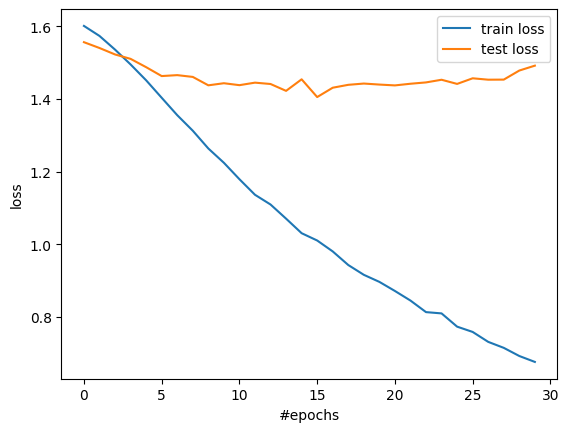

In [97]:
## Plot train_loss, test_loss
num_epochs = CONFIG['epochs']
plt.plot(np.arange(num_epochs), history_model["train_loss"], label='train loss')
plt.plot(np.arange(num_epochs), history_model["test_loss"], label='test loss')
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.legend()

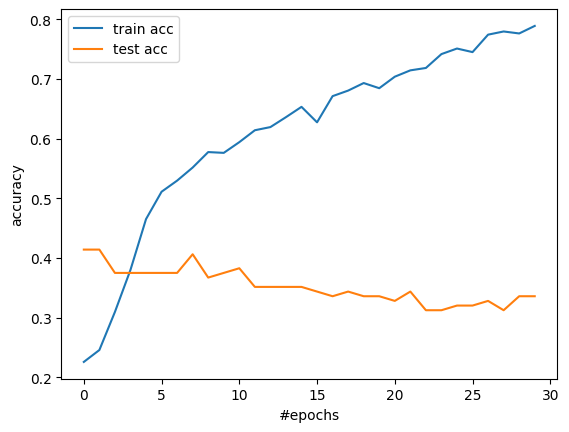

In [98]:
## Plot accuracy

plt.plot(np.arange(num_epochs), history_model["train_acc"], label='train acc')
plt.plot(np.arange(num_epochs), history_model["test_acc"], label='test acc')
plt.xlabel('#epochs')
plt.ylabel('accuracy')
plt.legend()

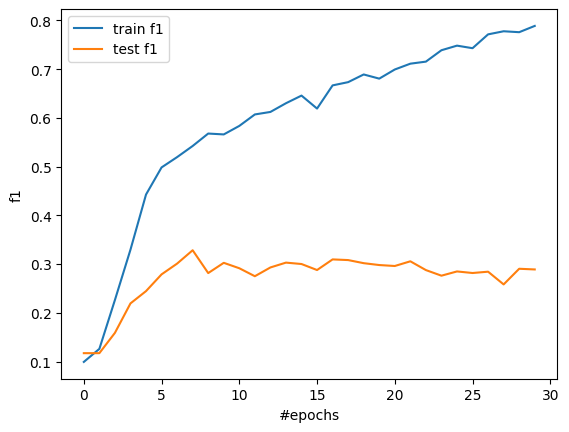

In [99]:
## Plot accuracy

plt.plot(np.arange(num_epochs), history_model["train_f1"], label='train f1')
plt.plot(np.arange(num_epochs), history_model["test_f1"], label='test f1')
plt.xlabel('#epochs')
plt.ylabel('f1')
plt.legend()

In [100]:
model

Baseline_Model(
  (fc1): Linear(in_features=1536, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [164]:
# torch.save(model.state_dict(), f'models/Baseline_model/state_dict_epoch{i}_batch_size{CONFIG["batch_size"]}.pth')